Ahora que hemos reducido el tamaño del dataset podemos continuar con el procesado de las imágenes

Para realizar este prepocesado se ha seguido el siguiente tutorial de Kaggle

https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
import itertools
# from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
# from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
# from keras.utils import Sequence
# from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 256
NUM_CLASSES = 5
SEED = 42
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

In [2]:
pathTrain='Training_Set_C'
pathTest='Test_Set_C'
pathVal='Evaluation_Set_C'

df_train = pd.read_csv(pathTrain + '/train.csv')
df_test = pd.read_csv(pathTest + '/test.csv')

x = df_train['ID']
y = df_train['Disease_Risk']

train_x, train_y = shuffle(x, y, random_state=SEED)

In [3]:
df= pd.concat([x,y], axis=1)
df

,ID,Disease_Risk
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
1915,1916,1
1916,1917,1
1917,1918,0
1918,1919,0


Las etiquetas de cada imagen se representan con 0 (clase normal) y 1 (tiene riesgo de enfermedad).

In [4]:
train_y.value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

<AxesSubplot:>

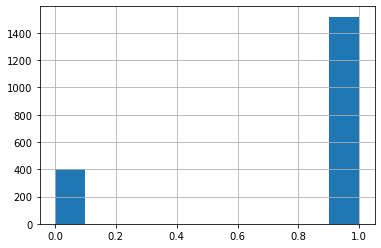

In [5]:
train_y.hist()

### 0. Visualizar Imágenes del dataset

Cada ID del paciente se corresponde con el nombre de la foto + .png

In [6]:
import random

#Obtenemos 25 imágenes para mostrarlas mas abajo
batch = random.sample(list(train_x), 25)

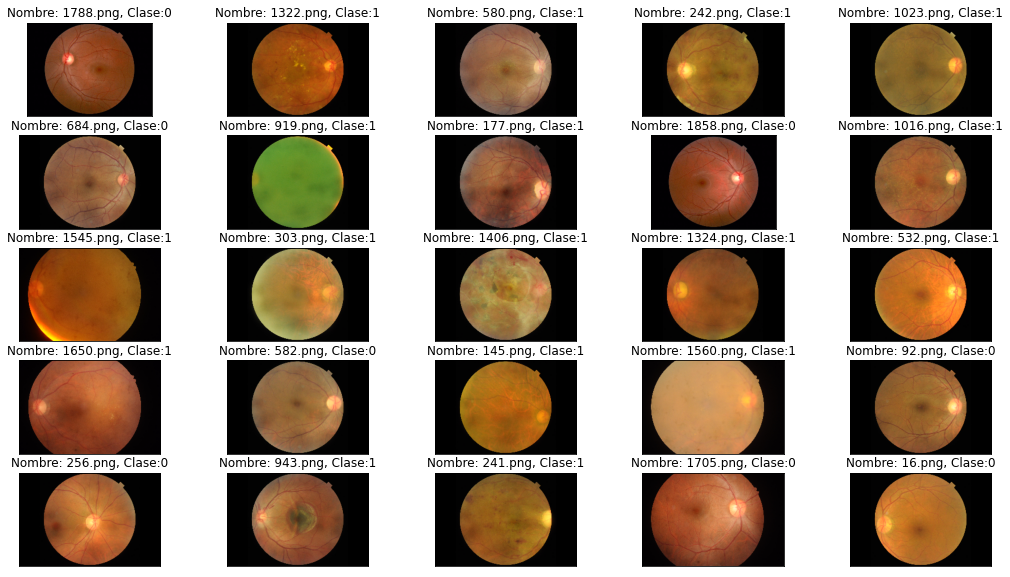

In [7]:
pathTrainImg = pathTrain + '/Training/'

fig = plt.figure(figsize=(18, 10))

for img, j in zip(batch, range(1,100)):
    ax = fig.add_subplot(5,5,j, xticks=[], yticks=[]) #Mostramos las imagenes en una cuadricula 5x5
    path = pathTrainImg + str(img) + '.png'
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.set_title('Nombre: %s, Clase:%d' % (str(img) + '.png', int(df.loc[df['ID'] == int(img)]['Disease_Risk'])))
    plt.imshow(image)

### 1. Mejora de las condiciones de iluminación

Podemos ahora verlas en escala de grises para poder mejor disntinguir algunas partes de la imagen. Por ejemplo se pueden ver mejor las venas.

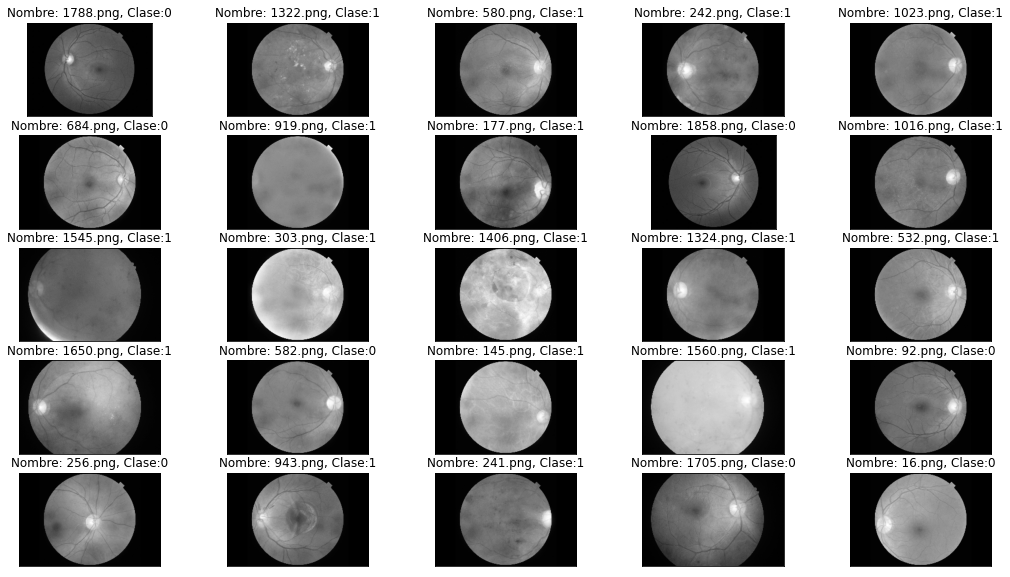

In [8]:
pathTrainImg = pathTrain + '/Training/'

fig = plt.figure(figsize=(18, 10))

for img, j in zip(batch, range(1,100)):
    ax = fig.add_subplot(5,5,j, xticks=[], yticks=[]) #Mostramos las imagenes en una cuadricula 5x5
    path = pathTrainImg + str(img) + '.png'
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ax.set_title('Nombre: %s, Clase:%d' % (str(img) + '.png', int(df.loc[df['ID'] == int(img)]['Disease_Risk'])))
    plt.imshow(image, cmap='gray')

#### Método de Ben Graham

Otra forma de mejorar las condiciones de iluminación

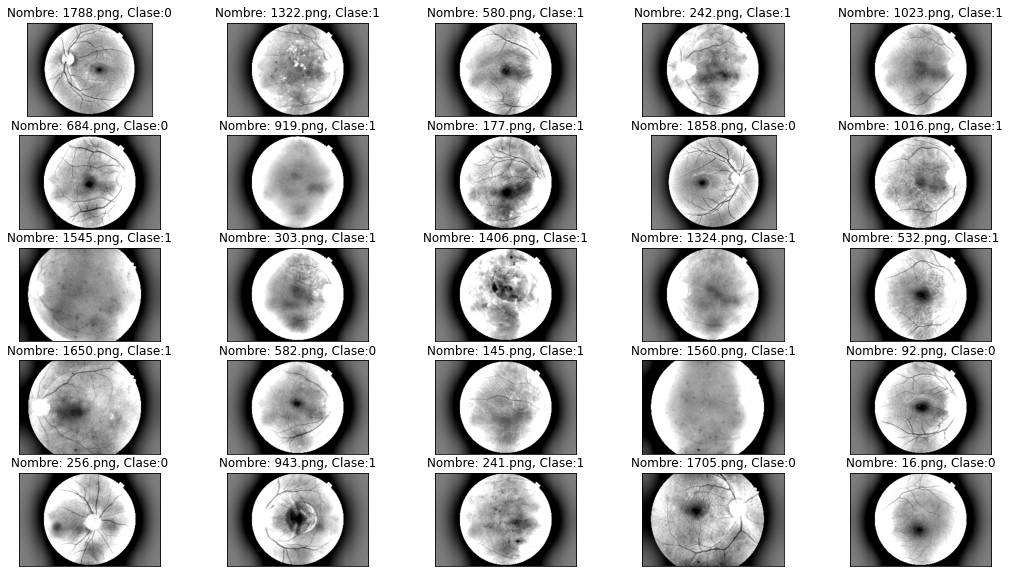

In [9]:
pathTrainImg = pathTrain + '/Training/'

fig = plt.figure(figsize=(18, 10))

for img, j in zip(batch, range(1,100)):
    ax = fig.add_subplot(5,5,j, xticks=[], yticks=[]) #Mostramos las imagenes en una cuadricula 5x5
    path = pathTrainImg + str(img) + '.png'
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # Añadimos la siguiente línea
    ax.set_title('Nombre: %s, Clase:%d' % (str(img) + '.png', int(df.loc[df['ID'] == int(img)]['Disease_Risk'])))
    plt.imshow(image, cmap='gray')

### 2. Recorte de imagenes

In [10]:
def crop_image(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        h,w,_=img.shape
#         print(h,w)
        img1=cv2.resize(crop_image1(img[:,:,0]),(w,h))
        img2=cv2.resize(crop_image1(img[:,:,1]),(w,h))
        img3=cv2.resize(crop_image1(img[:,:,2]),(w,h))
        
#         print(img1.shape,img2.shape,img3.shape)
        img[:,:,0]=img1
        img[:,:,1]=img2
        img[:,:,2]=img3
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

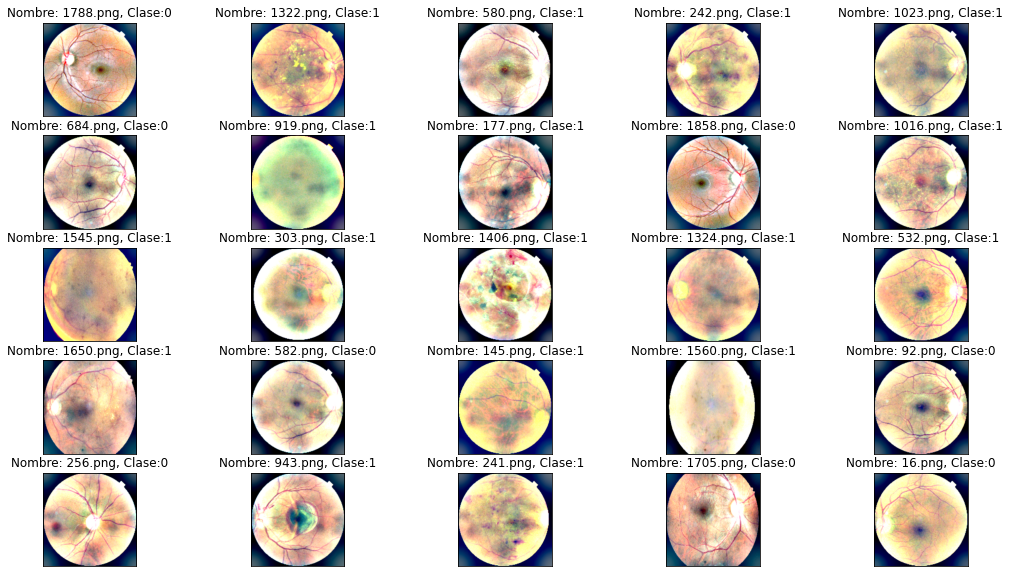

In [11]:
fig = plt.figure(figsize=(18, 10))

for img, j in zip(batch, range(1,100)):
    ax = fig.add_subplot(5,5,j, xticks=[], yticks=[]) #Mostramos las imagenes en una cuadricula 5x5
    path = pathTrainImg + str(img) + '.png'
    image = cv2.imread(path)
    image = load_ben_color(path,sigmaX=30)
    ax.set_title('Nombre: %s, Clase:%d' % (str(img) + '.png', int(df.loc[df['ID'] == int(img)]['Disease_Risk'])))
    plt.imshow(image)

En el método utiliza sigmaX = 10 porque se obtienen mejores resultados.

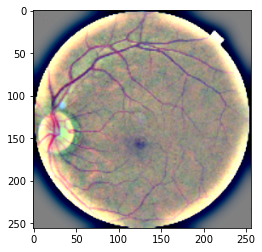

In [13]:
img = load_ben_color(path, sigmaX=10)
plt.imshow(img)

Imagen original, vemos que en la imagen de arriba las venas se notan bastante mas.

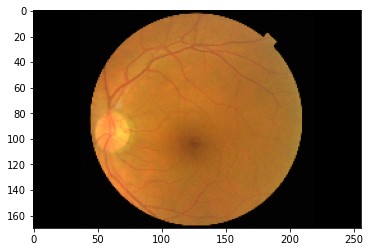

In [16]:
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)